In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!ls -a ~/.kaggle

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new
!unzip utkface-new.zip

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# **Preproccess**

In [4]:
width = height = 224
batch_size = 32
images = [] #X
ages = [] #Y

for image_name in os.listdir("/content/UTKFace"):
  #The first part of file names are the people ages(target) so:
  ages.append(int(image_name.split('_')[0]))

  #Read images and append them to X:
  image = cv2.imread(f"/content/UTKFace/{image_name}")
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(width,height))
  images.append(image)

In [ ]:
images = pd.Series(images, name='Images')
ages = pd.Series(ages, name = "Ages")

DataFrame = pd.concat([images,ages], axis=1)
DataFrame.head()

24


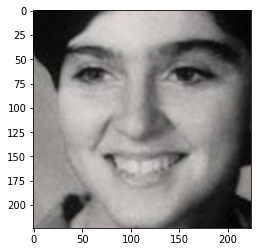

In [6]:
print(DataFrame["Ages"][0])
plt.imshow(DataFrame['Images'][0])
plt.show()

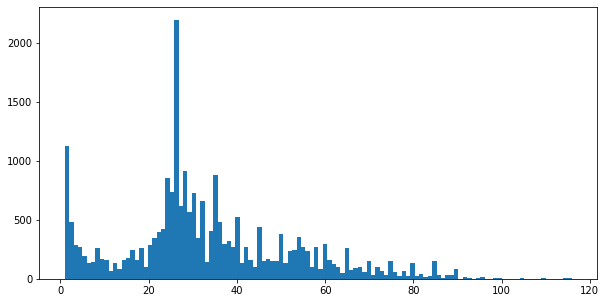

In [7]:
plt.figure(figsize=(10,5))
plt.hist(DataFrame['Ages'],bins=DataFrame['Ages'].max())
plt.show()

In [8]:
# Drop out some children who are under 4 years old
under_4 = DataFrame[DataFrame['Ages'] <= 4]
under_4_new = under_4.sample(frac = 0.3)

up_4 = DataFrame[DataFrame['Ages'] >= 4]

DataFrame = pd.concat([under_4_new, up_4], axis=0)

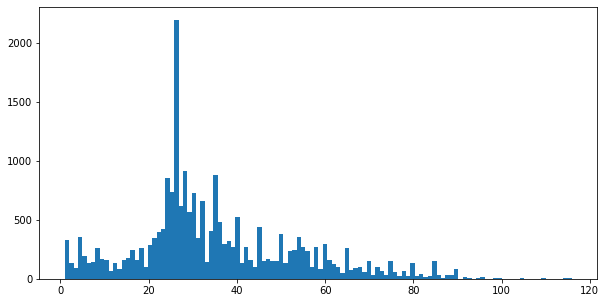

In [10]:
plt.figure(figsize=(10,5))
plt.hist(DataFrame['Ages'],bins=DataFrame['Ages'].max())
plt.show()

In [9]:
DataFrame = DataFrame[DataFrame['Ages'] < 80 ]

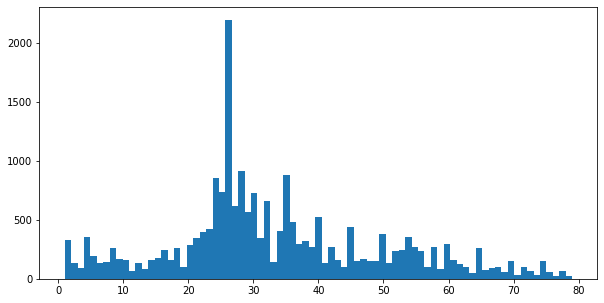

In [12]:
plt.figure(figsize=(10,5))
plt.hist(DataFrame['Ages'],bins=DataFrame['Ages'].max())
plt.show()

In [10]:
X = np.array(DataFrame['Images'].values.tolist())
Y = np.array(DataFrame['Ages'].values.tolist())
print(X.shape)
print(Y.shape)

(21791, 224, 224, 3)
(21791,)


In [11]:
X_train,X_val,Y_train, Y_val = train_test_split(X,Y, test_size = 0.2)
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(17432, 224, 224, 3)
(4359, 224, 224, 3)
(17432,)
(4359,)


In [ ]:
idg = ImageDataGenerator(rescale= 1./255 ,
                         horizontal_flip = True,
                         )

train_data = idg.flow(X_train,Y_train, batch_size = batch_size)
val_data = idg.flow(X_val,Y_val, batch_size = batch_size)

# **Model**

In [28]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape = (width, height, 3),
    weights = "imagenet",
    include_top = False,
    pooling = "avg"
)

In [29]:
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [30]:
model = tf.keras.Sequential([
    base_model,
    Dropout(0.5),
    Dense(1, activation = 'relu')                         
])

In [31]:
model.compile(optimizer=Adam(learning_rate=0.001),
loss = tf.keras.losses.mse)

In [ ]:
model.fit(train_data,
          validation_data = val_data,
          epochs = 20,
          shuffle = True)

# **Inference**

In [34]:
  image = cv2.imread("/content/5c49b07e945f0.jpg")
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(width,height))
  image = image / 255.0
  image = image[np.newaxis, ...]

  result = model.predict(image)
  print(result)

[[0.]]
